# EDA and Data Cleaning for Indicator Clustering
Unsupervised Learning Component of Milestone II group project:

Exploring Wordplay and Misdirection in Cryptic Crossword Clues with Natural Language Processing

## Imports

In [1]:
# imports
import os
from pathlib import Path
import pandas as pd
import numpy as np
import re
import string
import unicodedata
import matplotlib.pyplot as plt

## Loading the Data

In [2]:
# ==========================
# PATHS & CONFIG
# ==========================
# 1. Detect environment
IS_COLAB = 'google.colab' in str(get_ipython())

if IS_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    PROJECT_ROOT = Path('/content/drive/MyDrive/SIADS 692 Milestone II/Milestone II - NLP Cryptic Crossword Clues')
else:
    # On local, move up from notebooks/ to project root
    # Adjust the number of .parent calls based on where this notebook sits
    PROJECT_ROOT = Path.cwd().parent 

DATA_DIR = PROJECT_ROOT / "data"
OUTPUT_DIR = PROJECT_ROOT / "outputs"


In [3]:
# Read each CSV file into a DataFrame
df_clues = pd.read_csv(f'{DATA_DIR}/clues_raw.csv')
df_indicators = pd.read_csv(f'{DATA_DIR}/indicators_raw.csv')
df_ind_by_clue = pd.read_csv(f'{DATA_DIR}/indicators_by_clue_raw.csv')
df_ind_consolidated = pd.read_csv(f'{DATA_DIR}/indicators_consolidated_raw.csv')
df_charades = pd.read_csv(f'{DATA_DIR}/charades_raw.csv')
df_charades_by_clue = pd.read_csv(f'{DATA_DIR}/charades_by_clue_raw.csv')

## Reformat `clue_ids`

### Indicators Table `clue_ids`

In [4]:
# Uncomment to see how the clue_id data looks before cleaning
#df_indicators.sample().style.set_properties(**{"white-space": "pre-wrap"})

In [5]:
# Instead of a string with redundant indices, extract only the clue_ids in
# brackets to create a list of integers
df_indicators["clue_ids"] = (
    df_indicators["clue_ids"]
    .str.findall(r"\[(\d+)\]")
    .apply(lambda xs: [int(x) for x in xs])
)

# Include a new column to keep track of how many clues have this indicator
df_indicators["num_clues"] = df_indicators["clue_ids"].apply(len)

In [6]:
df_indicators.sample(3).style.set_properties(**{"white-space": "pre-wrap"})

,ind_id,wordplay,indicator,clue_ids,num_clues
12653,12654,insertion,found on board,[424073],1
9052,9053,container,to reserve,[646573],1
11355,11356,homophone,by all accounts,[11706],1


### Charades Table `clue_ids`

In [7]:
# Uncomment to see what the clue_ids look like before cleaning
#df_charades.sample().style.set_properties(**{"white-space": "pre-wrap"})

In [8]:
# Instead of a string with redundant indices, extract only the clue_ids in
# brackets to create a list of integers
df_charades["clue_ids"] = (
    df_charades["clue_ids"]
    .str.findall(r"\[(\d+)\]")
    .apply(lambda xs: [int(x) for x in xs])
)

# Include a new column to keep track of how many clues have this charade
df_charades["num_clues"] = df_charades["clue_ids"].apply(len)

In [9]:
df_charades.sample(3).style.set_properties(**{"white-space": "pre-wrap"})

,charade_id,charade,charade_answer,clue_ids,num_clues
14185,14186,donkey kissed,ASS PECKED,[126141],1
51404,51405,to go over,BRIDGE,[6432],1
24139,24140,idiots,NITS,[150577],1


## Helper Functions

### `clue_info()` - Investigate A Clue

`clue_info(n)` displays all the basic and derived information for the clue with `clue_id = n`.

In [10]:
# View all the info for a specific clue (by clue_id), including
# clue surface, answer, definition, charades, and indicators
def clue_info(n):
  clue_cols = ['clue_id', 'clue', 'answer', 'definition', 'source_url']
  display(
      df_clues[df_clues['clue_id'] == n][clue_cols].style.set_properties(
        subset=["clue", 'source_url'],
        **{"white-space": "pre-wrap"}
    )
      )
  print()
  display(df_charades_by_clue[df_charades_by_clue['clue_id']== n])
  print()
  display(df_ind_by_clue[df_ind_by_clue["clue_id"] == n])
  print()
  display(df_indicators[df_indicators['clue_ids'].apply(lambda lst: n in lst)])


In [11]:
clue_info(623961)

,clue_id,clue,answer,definition,source_url
620921,623961,"Crêpe in France, Breton one containing local milk, not Italian (6)",FLAUNE,Crêpe,https://www.fifteensquared.net/2022/03/29/azed-2597/


,clue_id,charade,charade_answer


,clue_id,alternation,anagram,container,deletion,hidden,homophone,insertion,reversal
81182,623961,abnormal,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,ind_id,wordplay,indicator,clue_ids,num_clues
0,1,alternation,abnormal,[623961],1


### `normalize()` - Remove punctuation, accents, make lowercase

In [12]:
# Normalize takes a string (clue surface, indicator, definition, answer),
# And returns the same text but with punctuation (including dashes) and
# accents removed, and all lowercase.
def normalize(s: str) -> str:
  # remove accents and punctuation, convert to lowercase
  s_normalized = ''.join(
      ch for ch in unicodedata.normalize('NFD', s)
      if unicodedata.category(ch).startswith(('L', 'N', 'Zs'))
  ).lower()

  return s_normalized

#### Normalization Question: Remove Dashes in Answer?

See Clue 624269. Should LA-DI-DA be normalized as:
* la di da
* la-di-da
* ladida

### `count_unique_clues()`
This helper function will let us count how many unique clues are represented in an indicator DataFrame.

In [13]:
def count_unique_clues(series):
  """
  Calculates the total number of unique elements across all lists in a pandas
  Series. Applied to a column of `clue_ids`, this will count the number of
  unique clues represented in an indicator dataframe.

  Args:
    series (pandas.Series): A Series where each element is a list.

  Returns:
    int: The total count of unique elements.
  """
  unique_elements = set()
  for sublist in series:
    if isinstance(sublist, list):
      unique_elements.update(sublist)
  return len(unique_elements)

## All Available Tables
* Indicators
* Indicator By Clue
* Indicators Consolidated
* Bonus Dictionary Version of Indicators Consolidated
* Clue
* Charade
* Charade by Clue

### Indicators

In [14]:
df_indicators.sample(3).style.set_properties(
        subset=["clue_ids"],
        **{"white-space": "pre-wrap"}
    )

,ind_id,wordplay,indicator,clue_ids,num_clues
1113,1114,anagram,calculation,[404394],1
9899,9900,deletion,rubbing,[489783],1
8406,8407,container,occupying,"[365659, 384458]",2


In [15]:
# Uncomment to prove that `indicator` is already normalized - no accents,
# punctuation (including dashes), or capital letters

# Create a column of normalized indicators
#df_indicators['indicator_normalized'] = df_indicators['indicator'].apply(normalize)

# Check out all rows where normalization changed the indicator
#df_indicators.loc[df_indicators['indicator'] != df_indicators['indicator_normalized']]

### Indicators by Clue

In [16]:
df_ind_by_clue.head()

,clue_id,alternation,anagram,container,deletion,hidden,homophone,insertion,reversal
0,90,NaN,transforming,NaN,NaN,NaN,NaN,NaN,NaN
1,97,NaN,ground,NaN,NaN,NaN,NaN,NaN,NaN
2,101,NaN,NaN,NaN,NaN,NaN,verbally,NaN,NaN
3,142,NaN,NaN,NaN,NaN,NaN,NaN,NaN,about to go back
4,145,NaN,NaN,NaN,NaN,NaN,NaN,NaN,returned


### Indicators Consolidated

This dataframe contains eight columns--one for each type of wordplay--and one row with a string of all consolidated indicators found in the dataset by George Ho.

This data is better represented as a dictionary, so we create `ind_by_wordplay_dict` from `df_ind_consolidated`.

In [17]:
df_ind_consolidated

,alternation,anagram,container,deletion,hidden,homophone,insertion,reversal
0,abnormal\nafter odd losses\nafter regular exci...,a bad way\na bit differently\na brew of\na coc...,a single\naboard\nabout\nabout t\nabout/confin...,a certain amount off\nabandoned\nabandoned by\...,a bit\na bit of\na bit of this\na bunch of\na ...,a report on\naccording to announcement\naccord...,a bit of\na contingent of\na feature of\na fic...,a cleric raised\na fastening device put up\na ...


### Dictionary for Indicators Consolidated

`ind_by_wordplay_dict` is a dictionary with wordplay types for the keys and a list of all indicators consolidated for each wordplay type.

Nathan points out that some words in this dictionary have '\' or other suspicious characters. But because we use `indicators` instead (it has clue IDs for each indicator), we're not bothering to clean this dictionary.

In [18]:
# Create a dictionary where the key is the wordplay type, and the value is
# the list of associated unique indicators.
ind_by_wordplay_dict = {}

for wordplay in df_ind_consolidated.columns:
  ind_by_wordplay_dict[wordplay] = df_ind_consolidated[wordplay].values[0].split('\n')

In [19]:
# Uncomment or change key to view all indicators for that wordplay
#ind_by_wordplay_dict['insertion']

In [20]:
# See how many unique indicators there are for each type of wordplay
for wordplay in ind_by_wordplay_dict:
  print(f"{wordplay}: {len(ind_by_wordplay_dict[wordplay])}")

alternation: 244
anagram: 7346
container: 1950
deletion: 877
hidden: 1110
homophone: 669
insertion: 2173
reversal: 1692


### Clues

Create normalized entries for the `clue`, `answer` and `definition` by removing punctuation and accents and making them all lowercase:
* `surface`: The clue without the '(n)' at the end. The surface reading only, with capitalization and punctuation preserved.
* `surface_normalized`: The clue surface without capitalization, punctuation, or accents.
* `answer_normalized`: The answer in lower case with punctuation (hypthens) and accents removed.
* `definition_normalized`: The definition in lower case with punctuation and accents removed.

There are 323 rows with NaN for a clue. Remove these rows before proceeding. There are also 2,259 rows with NaN for `answer` and 149,096 rows with NaN for `definition`. However, because we're only concerned here with indicators (and verifying that the indicators are found in the clue), we will only drop the rows with NaN for `clue`.

In [21]:
# Uncomment to see how many rows have NaN for 'clue', 'answer', or 'definition'
#df_clues['clue'].value_counts(dropna=False).head()
#df_clues['answer'].value_counts(dropna=False).head()
#df_clues['definition'].value_counts(dropna=False).head()

# Drop all rows where the clue or answer is NaN (they are type float, and we want clue to be a string)
df_clues.dropna(subset=['clue', 'answer'], inplace=True)

In [22]:
# Surface: remove trailing numeric parentheses in clue
df_clues['surface'] = df_clues['clue'].astype(str).apply(lambda x: re.sub(r'\s*\(\d+(?:[,\s-]+\d+)*\)$', '', x))

In [23]:
# Create surface normalized - no accents, punctuation, capitalized letters
df_clues['surface_normalized'] = df_clues['surface'].astype(str).apply(normalize)

# Create answer normalized - no accents, punctuation, capitalized letters
df_clues['answer_normalized'] = df_clues['answer'].astype(str).apply(normalize)

# Create definition normalized - no accents, punctuation, capitalized letters
#df_clues['definition_normalized'] = df_clues['definition'].astype(str).apply(normalize)

In [24]:
df_clues.head()

,clue_id,clue,answer,definition,clue_number,puzzle_date,puzzle_name,source_url,source,surface,surface_normalized,answer_normalized
0,1,"Acquisitive chap, as we see it (8)",COVETOUS,Acquisitive,1a,2019-08-08,Times 27424,https://times-xwd-times.livejournal.com/218581...,times_xwd_times,"Acquisitive chap, as we see it",acquisitive chap as we see it,covetous
1,2,Back yard fencing weak and sagging (6),DROOPY,sagging,5a,2019-08-08,Times 27424,https://times-xwd-times.livejournal.com/218581...,times_xwd_times,Back yard fencing weak and sagging,back yard fencing weak and sagging,droopy
2,3,"Stripping off uniform, love holding colonel's ...",UNCLOTHING,Stripping,8a,2019-08-08,Times 27424,https://times-xwd-times.livejournal.com/218581...,times_xwd_times,"Stripping off uniform, love holding colonel's ...",stripping off uniform love holding colonels coat,unclothing
3,4,Without a mark where they should be gained (4),EXAM,where they should be gained,9a,2019-08-08,Times 27424,https://times-xwd-times.livejournal.com/218581...,times_xwd_times,Without a mark where they should be gained,without a mark where they should be gained,exam
4,5,"Put a stop to Rugby's foul school leader (5,2,...",KNOCK ON THE HEAD,Put a stop to,10a,2019-08-08,Times 27424,https://times-xwd-times.livejournal.com/218581...,times_xwd_times,Put a stop to Rugby's foul school leader,put a stop to rugbys foul school leader,knock on the head


### Charades by Clue

In [25]:
df_charades_by_clue.sample(3)

,clue_id,charade,charade_answer
110193,591924,ration,DOLE
21489,55463,religious leader,POPE
55448,157383,the inferno,HELL


### Charades

In [26]:
df_charades.sample(3).style.set_properties(
        subset=["clue_ids"],
        **{"white-space": "pre-wrap"}
    )

,charade_id,charade,charade_answer,clue_ids,num_clues
19575,19576,friendly type,HUGGER,[228534],1
28192,28193,little kid,MITE,[184903],1
18294,18295,fitful pain,COLIC,[184380],1


# Data Requirements & Unresolved Dilemmas


As we apply the requirements, our dataset of valid indicators will keep decreasing. Create a dataframe to keep track of how much data we're losing at each step.

* Once we restrict our dataset, do we have enough indicators for clustering (assume $2 < k < 12$)?

In [27]:
# Create a dataframe and add the counts from Indicators
df_ind_counts = pd.DataFrame(columns=["unique_inds"])
df_ind_counts['unique_inds'] = df_indicators.groupby(by=['wordplay']).count()['indicator']

# Also keep track of the total number of indicators
ind_total = df_ind_counts['unique_inds'].sum()

In [28]:
# Include a column that counts indicators by clue, which will
# double-count any indicator appearing in multiple clues
df_ind_counts['all_instances'] = df_ind_by_clue.count()

# Rearrange the columns to go from large to small, remove counts from
# ind_consolidated because they don't have associated clue IDs.
df_ind_counts = df_ind_counts[['all_instances', 'unique_inds']]

In [29]:
print(f"Total Number of Clues: {len(df_clues):,}")
print(f"Total Unique Indicators: {ind_total:,}")
print(f"Total Instances of Indicators in All Clues: {df_ind_counts['all_instances'].sum():,}")
print(f"Total Number of Clues Containing Indicator(s): {df_ind_by_clue['clue_id'].count():,}")

Total Number of Clues: 658,031
Total Unique Indicators: 15,735
Total Instances of Indicators in All Clues: 93,867
Total Number of Clues Containing Indicator(s): 88,037


In [30]:
df_ind_counts

,all_instances,unique_inds
wordplay,,
alternation,769,244
anagram,45648,7121
container,14144,1909
deletion,2093,873
hidden,3381,1110
homophone,4672,663
insertion,11171,2155
reversal,11989,1660


Summary:
* Of the entire dataset of 660,613 cryptic crossword clues, 88,037 clues came from blog posts where indicators could be identified. (from `df_ind_by_clue`)
* Because sometimes clues have more than one indicator, a total of 93,867 indicators were found in the dataset, and are associated with a parsed clue. (from `df_ind_by_clue`)
* CCCs reuse indicators. Of the 93,867 indicators identified in the data, only 15,735 are unique.
* More unique indicators appear in `df_ind_consolidated` (16,061) than in `df_indicators` (15,735). We cannot easily discover why because the Indicators Consolidated table was stripped of context.
* <b>We will use the Indicators table</b> going forward because it cites which clues used that indicator. We can verify the quality of the data better.
* Note that a common indicator like "within" may be counted twice: once as a hidden indicator and once as a container indicator. Therefore, if we were to export the 15,735 indicator words, there would be duplicates for the different types of wordplay.



### Indicator word(s) must appear in the clue surface text

To make sure that the indicator word wasn't incorrectly parsed, it must appear in the clue as a fully intact word, not just a segment of a word.

This will exclude some clues that use a compound word to contain both the indicator and fodder, like Minute Cryptic's "This semicircle encircles you (4)". Semi is a selection indicator telling you to take half of "circle".

In [31]:
# Add a column with a list of VERIFIED clue IDs: where we know the indicator
# appeared in the surface text as intact words.

# Build fast lookup dictionary
clue_lookup = df_clues.set_index("clue_id")["surface_normalized"].to_dict()

# Given an indicator and its list of clue_ids where it appears,
# return a new list of clue_ids where the indicator definitely
# appears in the normalized clue surface as intact words.
def verify_clues(indicator, clue_ids):
    if not clue_ids:
        return []

    # Escape regex special characters inside indicator
    pattern = rf"\b{re.escape(indicator)}\b"

    verified = []

    for cid in clue_ids:
        surface = clue_lookup.get(cid)

        if surface and re.search(pattern, surface):
            verified.append(cid)

    return verified


# add the column for the list of verified clue_ids
df_indicators["clue_ids_verified"] = df_indicators.apply(
    lambda row: verify_clues(row["indicator"], row["clue_ids"]),
    axis=1
)


In [32]:
# Add a column that counts the number of verified clue_ids for each indicator
df_indicators['num_clues_verified'] = df_indicators['clue_ids_verified'].apply(len)

In [33]:
# Uncomment to inspect the indicators table
df_indicators.sample(3)

,ind_id,wordplay,indicator,clue_ids,num_clues,clue_ids_verified,num_clues_verified
9164,9165,container,when describing,[287579],1,[287579],1
1119,1120,anagram,can be confused,[415571],1,[415571],1
12865,12866,insertion,impounded by,"[3702, 406170, 637299]",3,"[3702, 406170]",2


In [34]:
# Inspect some clues where the indicators were invalid
#clue_info(635505) # indicator not in clue or on webpage
#clue_info(591484) # indicator not in clue or on webpage
#clue_info(627621) # indicator not in clue, defn NaN
#clue_info(422350) # indicator is a partial word in clue bc blogger error
#clue_info(76808) # misparsed 'hidden' formatting, the identified indicator is actually fodder

In [35]:
# Keep track of how many indicators are left if we keep only ones with
# at least one verified clue_id
mask = df_indicators['num_clues_verified'] > 0
df_ind_counts['verified_inds'] = df_indicators[mask].groupby(by=['wordplay']).count()['indicator']

In [36]:
df_ind_counts.style.format('{:,}')


,all_instances,unique_inds,verified_inds
wordplay,,,
alternation,769,244,216
anagram,"45,648","7,121","6,610"
container,"14,144","1,909","1,728"
deletion,"2,093",873,695
hidden,"3,381","1,110",971
homophone,"4,672",663,565
insertion,"11,171","2,155","1,915"
reversal,"11,989","1,660","1,495"


In [37]:
df_ind_counts.sum()

all_instances    93867
unique_inds      15735
verified_inds    14195
dtype: int64

### Character Lengths of Indicators Must Be Reasonable

Investigate indicators that are 1, 2, or 3 characters long for invalid words. These may already be caught when we excluded indicators that did not appear intact in the clue.

Also investigate the longest indicators.

NOTE: Once we limit ourselves to only verified indicators (they appear as intact words in the clue surface), the indicators suspicious because of their length all get excluded. All the shortest and longest indicators look like real words.

In [38]:
# Create a column for the number of characters in the indicator phrase
df_indicators['num_chars'] = df_indicators['indicator'].apply(len)

In [39]:
# See the counts for each indicator length, just for verified indicators
mask = (df_indicators['num_clues_verified'] > 0)
display(df_indicators[mask]['num_chars'].value_counts(dropna=False).sort_index())


num_chars
2       12
3       83
4      342
5      595
6      919
7     1445
8     1555
9     1501
10    1501
11    1270
12    1078
13     911
14     704
15     653
16     424
17     350
18     248
19     170
20     110
21     110
22      58
23      51
24      36
25      19
26      15
27      11
28      10
29       5
31       5
32       2
33       1
36       1
Name: count, dtype: int64

<Axes: xlabel='num_chars'>

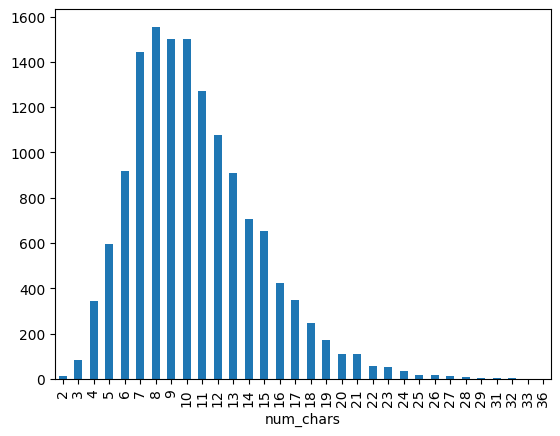

In [40]:
# Visualize the distribution of indicator length (as number of characters)
# just for unique indicators with verified clues
df_indicators[mask]['num_chars'].value_counts().sort_index().plot(kind='bar')

In [41]:
# Uncomment to manually inspect 2-character verified indicators
#cols = ['wordplay', 'indicator', 'clue_ids_verified', 'num_clues_verified', 'num_clues']
#mask = (df_indicators['num_clues_verified'] > 0) & (df_indicators['num_chars'] == 2)
#df_indicators[mask][cols].head(12).sort_values(by='num_clues_verified', ascending=False)

In [42]:
# Uncomment to manually inspect 3-character verified indicators
#cols = ['wordplay', 'indicator', 'clue_ids_verified', 'num_clues_verified', 'num_clues']
#mask = (df_indicators['num_clues_verified'] > 0) & (df_indicators['num_chars'] == 3)
#df_indicators[mask][cols].head(83).sort_values(by='num_clues_verified', ascending=False)

In [77]:
# Uncomment to manually inspect the longest verified indicators
#cols = ['wordplay', 'indicator', 'clue_ids_verified', 'num_clues', 'num_chars']
#mask = (df_indicators['num_clues_verified'] > 0) & (df_indicators['num_chars'] > 25)
#df_indicators[mask][cols].sort_values(by='num_chars', ascending=False)

### Issue: Some indicator phrases may contain some fodder
Inspecting the longest verified indicators, it's possible that some of these phrases contain more than just the indicator, but they all look like an indicator is at least present. 

If we later represent these as semantic vectors using a SentenceTransformer model, the extra fodder words could be a source of noise. We may want to exclue indicators with long character counts, or even create a data cleaning step that reduces these longer phrases to the known indicator (phrases) they contain.

# Verifiable Wordplay Types

### Hiddens (FWD & REV)

Letters to hiddens appear directly in the clue surface, either normally or in reverse, ignoring punctuation and spaces.

This finds 23,079 clues where the answer is hidding going forwards and 6,823 where the answer is hidden in reverse. However, these are overestimates because the answers have not been verified and include some very short malformed answers that are easy to find.

In [44]:
df_clues.sample()

,clue_id,clue,answer,definition,clue_number,puzzle_date,puzzle_name,source_url,source,surface,surface_normalized,answer_normalized
533378,533379,Woman holding up entry form is dodgy (7),EVASIVE,dodgy,7d,2017-03-24,"No 11963, Friday 24 Mar 2017, Gridman",https://thehinducrosswordcorner.blogspot.com/2...,thehinducrosswordcorner,Woman holding up entry form is dodgy,woman holding up entry form is dodgy,evasive


In [45]:
df_indicators.sample()

,ind_id,wordplay,indicator,clue_ids,num_clues,clue_ids_verified,num_clues_verified,num_chars
9946,9947,deletion,shunned,"[470037, 660814]",2,[470037],1,7


In [46]:
# Compute hidden_fwd and hidden_rev
# Helper function to remove all whitespace for hidden word search
def remove_all_whitespace(text: str) -> str:
    if isinstance(text, str):
        return text.replace(" ", "")
    return ""

# Create 'answer_no_spaces' from 'answer_normalized'
df_clues['answer_no_spaces'] = df_clues['answer_normalized'].apply(remove_all_whitespace)

# Create 'surface_no_spaces' from 'surface_normalized'
df_clues['surface_no_spaces'] = df_clues['surface_normalized'].apply(remove_all_whitespace)

# Calculate 'hidden_fwd'
df_clues['hidden_fwd'] = df_clues.apply(
    lambda row: row['answer_no_spaces'] in row['surface_no_spaces'],
    axis=1
)

# Calculate 'hidden_rev'
df_clues['answer_no_spaces_rev'] = df_clues['answer_no_spaces'].apply(lambda x: x[::-1])
df_clues['hidden_rev'] = df_clues.apply(
    lambda row: row['answer_no_spaces_rev'] in row['surface_no_spaces'],
    axis=1
)

In [47]:
df_clues[df_clues['hidden_fwd']].shape[0]

23054

In [48]:
df_clues[df_clues['hidden_rev']].shape[0]

6798

In [84]:
df_clues.head()

,clue_id,clue,answer,definition,clue_number,puzzle_date,puzzle_name,source_url,source,surface,surface_normalized,answer_normalized,answer_no_spaces,surface_no_spaces,hidden_fwd,answer_no_spaces_rev,hidden_rev,alternation,is_anagram_in_surface,answer_letter_count
0,1,"Acquisitive chap, as we see it (8)",COVETOUS,Acquisitive,1a,2019-08-08,Times 27424,https://times-xwd-times.livejournal.com/218581...,times_xwd_times,"Acquisitive chap, as we see it",acquisitive chap as we see it,covetous,covetous,acquisitivechapasweseeit,False,suotevoc,False,False,False,8
1,2,Back yard fencing weak and sagging (6),DROOPY,sagging,5a,2019-08-08,Times 27424,https://times-xwd-times.livejournal.com/218581...,times_xwd_times,Back yard fencing weak and sagging,back yard fencing weak and sagging,droopy,droopy,backyardfencingweakandsagging,False,ypoord,False,False,False,6
2,3,"Stripping off uniform, love holding colonel's ...",UNCLOTHING,Stripping,8a,2019-08-08,Times 27424,https://times-xwd-times.livejournal.com/218581...,times_xwd_times,"Stripping off uniform, love holding colonel's ...",stripping off uniform love holding colonels coat,unclothing,unclothing,strippingoffuniformloveholdingcolonelscoat,False,gnihtolcnu,False,False,False,10
3,4,Without a mark where they should be gained (4),EXAM,where they should be gained,9a,2019-08-08,Times 27424,https://times-xwd-times.livejournal.com/218581...,times_xwd_times,Without a mark where they should be gained,without a mark where they should be gained,exam,exam,withoutamarkwheretheyshouldbegained,False,maxe,False,False,False,4
4,5,"Put a stop to Rugby's foul school leader (5,2,...",KNOCK ON THE HEAD,Put a stop to,10a,2019-08-08,Times 27424,https://times-xwd-times.livejournal.com/218581...,times_xwd_times,Put a stop to Rugby's foul school leader,put a stop to rugbys foul school leader,knock on the head,knockonthehead,putastoptorugbysfoulschoolleader,False,daehehtnokconk,False,False,False,14


In [ ]:
# Compute answer letter count (needed for hidden_fwd filtering below and later exports)
df_clues['answer_letter_count'] = df_clues['answer_no_spaces'].apply(len)

In [88]:
# See the counts for each answer length, just for verified hidden_fwd
mask = (df_clues['hidden_fwd']) & (df_clues['answer_letter_count'] == 4)
cols = ['clue', 'answer']
df_clues[mask][cols]

,clue,answer
10,A little house might ... be this? (4),SEMI
290,Pernickety person — kind inside (4),TYPE
320,Bed or mattress? It may be found in here (4),DORM
591,Timmy Thompson’s secret fantasy,MYTH
751,Weapons found in farmstead (4),ARMS
...,...,...
659938,Open from sundown (4),UNDO
660181,"Food in retreat, scrumptious (4)",EATS
660193,Some people accepting petition (4),PLEA
660246,"Shabby inside bungalow, or not? (4)",WORN


Maybe restrict to 4+ letter answer? Also verify that answer have the correct letter count and format. 

## Alternation

If the answer word appears in the surface as alternating letters, label it as verified alternation wordplay.

This found 4,220 clues with alternation, but some of those will be erroneous (short) answers.

In [49]:
# An efficient way to find alternation

# We cache the regex pattern to avoid re-compiling inside the loop
# This looks for the answer characters with exactly one char between them
def check_alternation_seq(ans, clue):
    if not ans or not clue:
        return False
    # Creates "A.N.S.W.E.R"
    pattern = ".".join(re.escape(c) for c in ans)
    return bool(re.search(pattern, clue))

# Applying to the dataframe
df_clues['alternation'] = [
    check_alternation_seq(ans, clue)
    for ans, clue in zip(df_clues['answer_no_spaces'], df_clues['surface_no_spaces'])
]

In [50]:
df_clues[df_clues['alternation']].shape[0]

4213

# Summary of Indicators

In [51]:
df_ind_counts.style.format('{:,}')

,all_instances,unique_inds,verified_inds
wordplay,,,
alternation,769,244,216
anagram,"45,648","7,121","6,610"
container,"14,144","1,909","1,728"
deletion,"2,093",873,695
hidden,"3,381","1,110",971
homophone,"4,672",663,565
insertion,"11,171","2,155","1,915"
reversal,"11,989","1,660","1,495"


In [52]:
df_ind_counts.sum().to_frame().T.style.format('{:,}')

,all_instances,unique_inds,verified_inds
0,"93,867","15,735","14,195"


<Axes: ylabel='wordplay'>

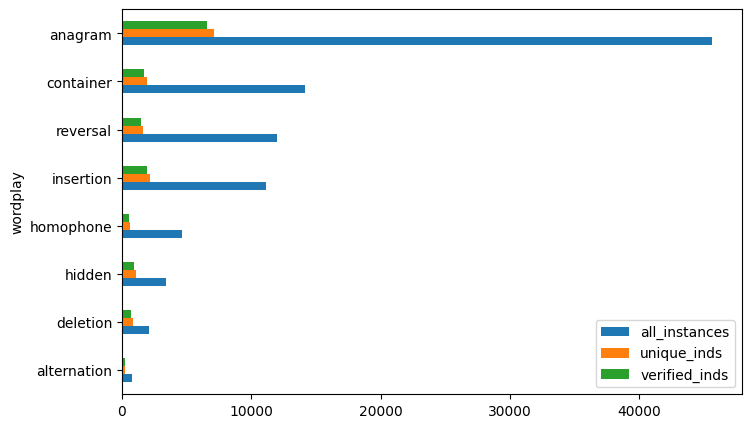

In [53]:
df_ind_counts.sort_values(by='all_instances').plot.barh(stacked=False, figsize=(8, 5))

In [54]:
# Add a column for the number of words within an indicator
df_indicators['ind_wc'] = df_indicators['indicator'].apply(lambda x: len(x.split()))

<Axes: xlabel='ind_wc'>

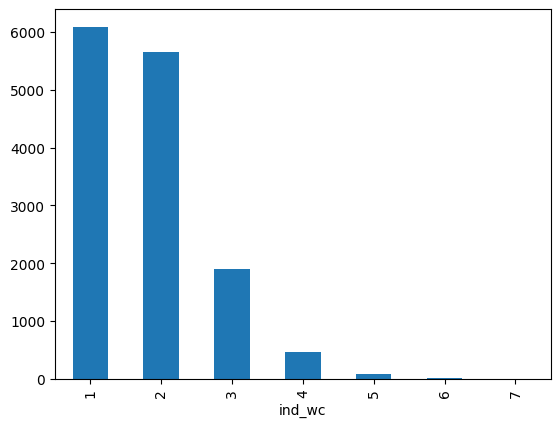

In [55]:
# Visualize the valid indicators by word count
mask = df_indicators['num_clues_verified'] > 0
df_indicators[mask]['ind_wc'].value_counts().sort_index().plot(kind='bar')

<Axes: xlabel='num_clues_verified'>

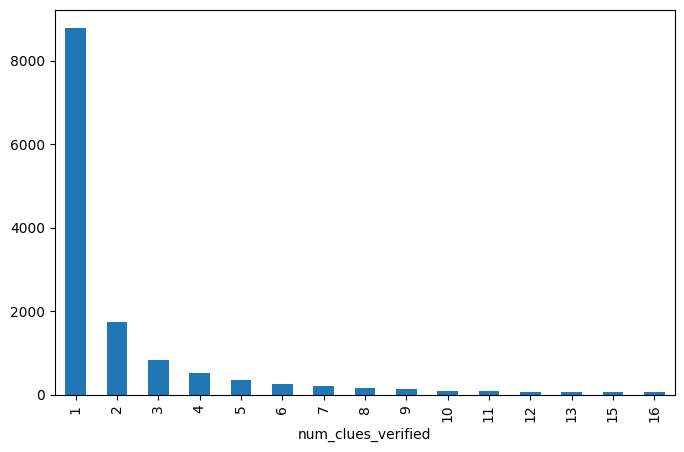

In [56]:
# Visualize the prevalence/redundancy of valid indicators
mask = df_indicators['num_clues_verified'] > 0
df_indicators[mask]['num_clues_verified'].value_counts().head(15).sort_index().plot(kind='bar', figsize=(8, 5))

In [57]:
# View some examples of the most common indicators
df_indicators[['num_clues_verified', 'indicator', 'wordplay']].sort_values(by='num_clues_verified', ascending=False).head(10)

,num_clues_verified,indicator,wordplay
12878,1487,in,insertion
7367,1251,about,container
4468,789,out,anagram
14173,660,back,reversal
15558,603,up,reversal
4278,540,new,anagram
11706,490,reportedly,homophone
14081,426,about,reversal
281,410,about,anagram
4651,390,possibly,anagram


# Export Verified Indicators for Downstream Stages

This section produces the output files consumed by Stage 2 (embedding generation) and Stage 5 (evaluation).

**Output files:**
- `verified_indicators_unique.csv` — One row per unique indicator string (12,622 rows). No labels. This is the input to Stage 2 (`02_embedding_generation_Victoria.ipynb`).
- `verified_clues_labeled.csv` — One row per verified (clue_id, indicator) pair (76,015 rows). Includes Ho blog labels and algorithmic ground-truth labels. Used for evaluation.

Note that `df_indicators` contains 14,195 verified rows because the same indicator string can appear under multiple wordplay types (e.g., "about" appears as container, reversal, and anagram — three rows). The deduplicated export collapses these to 12,622 unique strings.

In [58]:
df_indicators.head()

,ind_id,wordplay,indicator,clue_ids,num_clues,clue_ids_verified,num_clues_verified,num_chars,ind_wc
0,1,alternation,abnormal,[623961],1,[],0,8,1
1,2,alternation,after odd losses,[139327],1,[139327],1,16,3
2,3,alternation,after regular excisions,[107211],1,[107211],1,23,3
3,4,alternation,alternately,[407055],1,[407055],1,11,1
4,5,alternation,alternating,[449798],1,[449798],1,11,1


In [59]:
mask = df_indicators['num_clues_verified'] > 0
print(len(df_indicators['indicator'].unique()))
print(len(df_indicators[mask]['indicator'].unique()))

13920
12622


# Export Deduplicated Unique Indicators

Deduplicated list of 12,622 unique indicator strings for Stage 2 embedding input. Each indicator appears exactly once regardless of how many wordplay types it is associated with.

In [ ]:
# Deduplicated list of unique indicator strings for Stage 2 embedding input
mask = df_indicators['num_clues_verified'] > 0
unique_indicators = (
    df_indicators[mask]['indicator']
    .drop_duplicates()
    .sort_values()
    .reset_index(drop=True)
)
unique_indicators.to_csv(
    DATA_DIR / 'verified_indicators_unique.csv',
    index=False,
    header=['indicator']
)
print(f"Saved {len(unique_indicators)} unique indicator strings to verified_indicators_unique.csv")

In [63]:
df_ind_counts.style.format('{:,}')

,all_instances,unique_inds,verified_inds,verified_one_word
wordplay,,,,
alternation,769,244,216,30
anagram,"45,648","7,121","6,610","3,429"
container,"14,144","1,909","1,728",774
deletion,"2,093",873,695,294
hidden,"3,381","1,110",971,440
homophone,"4,672",663,565,154
insertion,"11,171","2,155","1,915",613
reversal,"11,989","1,660","1,495",357


In [64]:
df_ind_counts.sum().to_frame().T.style.format('{:,}')

,all_instances,unique_inds,verified_inds,verified_one_word
0,"93,867","15,735","14,195","6,091"


# Task
Create a DataFrame named `df_alternation` containing only indicators related to 'alternation' wordplay. This DataFrame should include the 'wordplay', 'indicator', and 'clue_ids_verified' columns, where 'clue_ids_verified' is a refined list of `clue_id`s for each indicator that corresponds to clues definitively identified as 'alternation' wordplay in `df_clues`. Finally, display the first few rows of `df_alternation`.

## Extract Alternation Clue IDs

### Subtask:
Create a set of `clue_id`s from `df_clues` where the 'alternation' column is True. This set will be used for efficient lookup.


**Reasoning**:
To efficiently store and retrieve clue IDs that exhibit alternation wordplay, I will filter the `df_clues` DataFrame to include only rows where the 'alternation' column is True, then extract the 'clue_id' column and convert it into a Python set.



In [65]:
alternation_clue_ids = set(df_clues[df_clues['alternation'] == True]['clue_id'])

**Reasoning**:
Now that we have a set of verified `clue_id`s for alternation wordplay, the next step is to filter the `df_indicators` DataFrame to include only indicators related to 'alternation' wordplay and then refine their `clue_ids_verified` lists to only contain `clue_id`s that are also present in the `alternation_clue_ids` set. This ensures that the indicators truly correspond to the 'alternation' wordplay identified in `df_clues`.



In [66]:
df_alternation = df_indicators[df_indicators['wordplay'] == 'alternation'].copy()

df_alternation['clue_ids_verified'] = df_alternation['clue_ids_verified'].apply(
    lambda x: [clue_id for clue_id in x if clue_id in alternation_clue_ids]
)

# Filter out rows where clue_ids_verified is empty after refinement
df_alternation = df_alternation[df_alternation['clue_ids_verified'].apply(len) > 0]

df_alternation = df_alternation[['wordplay', 'indicator', 'clue_ids_verified']]

df_alternation.head()

,wordplay,indicator,clue_ids_verified
2,alternation,after regular excisions,[107211]
3,alternation,alternately,[407055]
7,alternation,alternatives,[411337]
8,alternation,an even distribution of fruit,[412172]
10,alternation,appearing alternately,[473579]


In [67]:
df_alternation.shape[0]

121

In [68]:
df_indicators[df_indicators['wordplay'] == 'alternation'].shape[0]

244

In [69]:
count_unique_clues(df_alternation['clue_ids_verified'])

255

In [70]:
count_unique_clues(df_indicators['clue_ids_verified'])

70959

In [71]:
count_unique_clues(df_indicators[df_indicators['wordplay'] == 'alternation']['clue_ids_verified'])

654

## Summary:

### Data Analysis Key Findings

*   A set named `alternation_clue_ids` was successfully created, containing 153 unique `clue_id`s corresponding to clues definitively identified as 'alternation' wordplay from the `df_clues` DataFrame.
*   A new DataFrame, `df_alternation`, was successfully constructed. It initially filtered `df_indicators` for rows where the 'wordplay' column was 'alternation'.
*   The `clue_ids_verified` column in `df_alternation` was refined to include only those `clue_id`s that were present in the `alternation_clue_ids` set, ensuring that each indicator is linked exclusively to verified 'alternation' clues.
*   Rows in `df_alternation` where the `clue_ids_verified` list became empty after refinement were removed, ensuring that all remaining indicators are associated with at least one verified alternation clue.
*   The final `df_alternation` DataFrame contains only the 'wordplay', 'indicator', and `clue_ids_verified` columns, with entries like 'after regular excisions', 'alternately', and 'alternatives' as indicators.

### Insights or Next Steps

*   The `df_alternation` DataFrame now provides a clean, verified dataset of alternation wordplay indicators and their associated clue IDs, which can be used for training a model to identify 'alternation' wordplay or for further linguistic analysis.
*   Further analysis could involve examining the commonality of specific indicators within the `clue_ids_verified` lists to understand which indicators are most frequently used for 'alternation' wordplay.


In [72]:
def check_anagram_in_surface(answer_no_spaces_text, surface_no_spaces_text):
    if not answer_no_spaces_text or not surface_no_spaces_text:
        return False

    answer_len = len(answer_no_spaces_text)
    if answer_len == 0:
        return False

    sorted_answer_chars = sorted(answer_no_spaces_text)

    for i in range(len(surface_no_spaces_text) - answer_len + 1):
        substring = surface_no_spaces_text[i : i + answer_len]
        if sorted(substring) == sorted_answer_chars:
            return True
    return False

# Apply this function to df_clues
df_clues['is_anagram_in_surface'] = df_clues.apply(
    lambda row: check_anagram_in_surface(row['answer_no_spaces'], row['surface_no_spaces']),
    axis=1
)

# Display the DataFrame with the new column
df_clues.head()

,clue_id,clue,answer,definition,clue_number,puzzle_date,puzzle_name,source_url,source,surface,surface_normalized,answer_normalized,answer_no_spaces,surface_no_spaces,hidden_fwd,answer_no_spaces_rev,hidden_rev,alternation,is_anagram_in_surface
0,1,"Acquisitive chap, as we see it (8)",COVETOUS,Acquisitive,1a,2019-08-08,Times 27424,https://times-xwd-times.livejournal.com/218581...,times_xwd_times,"Acquisitive chap, as we see it",acquisitive chap as we see it,covetous,covetous,acquisitivechapasweseeit,False,suotevoc,False,False,False
1,2,Back yard fencing weak and sagging (6),DROOPY,sagging,5a,2019-08-08,Times 27424,https://times-xwd-times.livejournal.com/218581...,times_xwd_times,Back yard fencing weak and sagging,back yard fencing weak and sagging,droopy,droopy,backyardfencingweakandsagging,False,ypoord,False,False,False
2,3,"Stripping off uniform, love holding colonel's ...",UNCLOTHING,Stripping,8a,2019-08-08,Times 27424,https://times-xwd-times.livejournal.com/218581...,times_xwd_times,"Stripping off uniform, love holding colonel's ...",stripping off uniform love holding colonels coat,unclothing,unclothing,strippingoffuniformloveholdingcolonelscoat,False,gnihtolcnu,False,False,False
3,4,Without a mark where they should be gained (4),EXAM,where they should be gained,9a,2019-08-08,Times 27424,https://times-xwd-times.livejournal.com/218581...,times_xwd_times,Without a mark where they should be gained,without a mark where they should be gained,exam,exam,withoutamarkwheretheyshouldbegained,False,maxe,False,False,False
4,5,"Put a stop to Rugby's foul school leader (5,2,...",KNOCK ON THE HEAD,Put a stop to,10a,2019-08-08,Times 27424,https://times-xwd-times.livejournal.com/218581...,times_xwd_times,Put a stop to Rugby's foul school leader,put a stop to rugbys foul school leader,knock on the head,knockonthehead,putastoptorugbysfoulschoolleader,False,daehehtnokconk,False,False,False


In [73]:
df_clues[df_clues['is_anagram_in_surface']].sample(10)

,clue_id,clue,answer,definition,clue_number,puzzle_date,puzzle_name,source_url,source,surface,surface_normalized,answer_normalized,answer_no_spaces,surface_no_spaces,hidden_fwd,answer_no_spaces_rev,hidden_rev,alternation,is_anagram_in_surface
369896,369897,Baked a Dorset recipe (7),ROASTED,NaN,3d,2012-12-07,Daily Telegraph 27038,http://bigdave44.com/2012/12/07/dt-27038/,bigdave44,Baked a Dorset recipe,baked a dorset recipe,roasted,roasted,bakedadorsetrecipe,False,detsaor,False,False,True
287710,287711,Turning device that could make you chatter,RATCHET,NaN,15a,2011-07-03,Everyman 337826 June 2011,https://www.fifteensquared.net/2011/07/03/ever...,fifteensquared,Turning device that could make you chatter,turning device that could make you chatter,ratchet,ratchet,turningdevicethatcouldmakeyouchatter,False,tehctar,False,False,True
293485,293486,Something blown from retro car in accident (7),OCARINA,Something blown,21d,2021-04-16,Daily Telegraph 29646,http://bigdave44.com/2021/04/16/dt-29646/,bigdave44,Something blown from retro car in accident,something blown from retro car in accident,ocarina,ocarina,somethingblownfromretrocarinaccident,True,aniraco,False,False,True
653829,656869,"Animal with horn, I gathered (5)",RHINO,Animal,2d,2023-04-26,Sunday Telegraph 3208,http://bigdave44.com/2023/04/26/st-3208-full-r...,bigdave44,"Animal with horn, I gathered",animal with horn i gathered,rhino,rhino,animalwithhornigathered,False,onihr,False,False,True
581106,584146,Somewhat rewarded athletes breaking promises (8),SEMIPROS,Somewhat rewarded athletes,16d,2019-09-14,"Saturday, September 14, 2019 — Canadian Icons",https://natpostcryptic.blogspot.com/2019/09/sa...,natpostcryptic,Somewhat rewarded athletes breaking promises,somewhat rewarded athletes breaking promises,semipros,semipros,somewhatrewardedathletesbreakingpromises,False,sorpimes,False,False,True
553454,553455,With which saw ahead sad end of sightseers? (15),FORESIGHTEDNESS,With which saw ahead,1d,2020-02-11,"No 12855, Tuesday 11 Feb 2020, Gridman",https://thehinducrosswordcorner.blogspot.com/2...,thehinducrosswordcorner,With which saw ahead sad end of sightseers?,with which saw ahead sad end of sightseers,foresightedness,foresightedness,withwhichsawaheadsadendofsightseers,False,ssendethgiserof,False,False,True
49823,49824,"Until returning into renamed, rebuilt landmark...",NOTRE-DAME,NaN,8d,2019-06-30,Mephisto 3069,https://times-xwd-times.livejournal.com/216480...,times_xwd_times,"Until returning into renamed, rebuilt landmark?",until returning into renamed rebuilt landmark,notredame,notredame,untilreturningintorenamedrebuiltlandmark,False,emaderton,False,False,True
472538,472539,So ‘hot meal’ (stew) is disgusting (9),LOATHSOME,NaN,18d,2010-04-08,Toughie 333,http://bigdave44.com/2010/04/08/toughie-333/,bigdave44,So ‘hot meal’ (stew) is disgusting,so hot meal stew is disgusting,loathsome,loathsome,sohotmealstewisdisgusting,False,emoshtaol,False,False,True
7528,7529,Solemn promise to Athena? Not entirely (4),OATH,Solemn promise,23a,2015-05-20,Quick Cryptic No 312,https://times-xwd-times.livejournal.com/131807...,times_xwd_times,Solemn promise to Athena? Not entirely,solemn promise to athena not entirely,oath,oath,solemnpromisetoathenanotentirely,True,htao,False,False,True
529800,529801,In sturdy condition for hard work (8),INDUSTRY,hard work,16d,2016-12-01,"No 11866, Thursday 01 Dec 2016, Arden",https://thehinducrosswordcorner.blogspot.com/2...,thehinducrosswordcorner,In sturdy condition for hard work,in sturdy condition for hard work,industry,industry,insturdyconditionforhardwork,False,yrtsudni,False,False,True


In [74]:
clue_info(261488)

,clue_id,clue,answer,definition,source_url
261487,261488,A deception fraudster used regularly (4),RUSE,A deception,https://www.fifteensquared.net/2014/03/07/financial-times-14564-by-alberich/


,clue_id,charade,charade_answer


,clue_id,alternation,anagram,container,deletion,hidden,homophone,insertion,reversal


,ind_id,wordplay,indicator,clue_ids,num_clues,clue_ids_verified,num_clues_verified,num_chars,ind_wc


In [ ]:
# answer_letter_count was computed earlier (after hidden detection)
# Verify it exists
assert 'answer_letter_count' in df_clues.columns, "answer_letter_count missing from df_clues"

In [76]:
df_clues['answer_letter_count'].value_counts(dropna=False)

answer_letter_count
7     115192
6     107437
8      97656
5      94664
9      75354
4      66124
10     38343
11     12504
12     12183
3      11777
13      9254
15      7154
14      6588
1       1528
2        841
16       431
17       257
18       188
19       136
20       104
22        77
21        75
23        53
24        30
26        23
28        14
25        10
30         9
27         5
29         5
33         3
31         3
32         2
39         2
37         1
45         1
46         1
92         1
38         1
Name: count, dtype: int64

# Export Verified Clues with Labels

This cell produces `verified_clues_labeled.csv`: one row per verified (clue, indicator) pair, with both the original Ho blog label and an algorithmically determined ground-truth label.

## Schema

| Column | Description |
|--------|-------------|
| `clue_id` | The clue ID from `df_clues` |
| `indicator` | The verified indicator string |
| `wordplay_ho` | The wordplay type label assigned by George Ho's blog parser (one of: alternation, anagram, container, deletion, hidden, homophone, insertion, reversal) |
| `wordplay_gt` | A ground-truth label derived from pattern detection on the clue surface. See priority ordering below. Null if no pattern fires or if `answer_letter_count < 4`. |
| `wordplay_gt_all` | Comma-separated list of ALL ground-truth labels that fired before priority resolution (for debugging/analysis). Also null if `answer_letter_count < 4`. |
| `answer_letter_count` | Number of letters in the answer, so downstream users can apply their own length filters |
| `label_match` | Boolean: True if `wordplay_ho == wordplay_gt` |

## Ground-truth priority ordering

When multiple patterns fire for the same clue, `wordplay_gt` is assigned by this priority:

1. **hidden** (if `hidden_fwd` is True) — most constrained: the exact answer letters appear consecutively in the surface
2. **reversal** (if `hidden_rev` is True) — same constraint but letters appear in reverse
3. **alternation** (if `alternation` is True) — answer letters appear at every-other position
4. **anagram** (if `is_anagram_in_surface` is True) — loosest: any permutation of a surface substring matches the answer

Hidden takes precedence over anagram because hidden is a strict subset of anagram (any hidden word is trivially also an anagram of the same substring). Without this priority, hidden clues would be mislabeled as anagram. Similarly, reversal is a strict subset of anagram. Alternation is prioritized over anagram because it requires a specific letter pattern rather than any permutation.

Answers shorter than 4 letters are excluded from ground-truth labeling because short answers produce many false-positive pattern matches (e.g., a 2-letter answer is easily "hidden" in any surface by coincidence).

## Note on duplicate rows

The same `(clue_id, indicator)` pair may appear multiple times if the same indicator string is listed under different wordplay types in `df_indicators`. Each such row will have a different `wordplay_ho`. This preserves the multi-label structure of the data.

In [ ]:
# === Step A: Explode clue_ids_verified and join with df_clues ===

# Start with verified indicators only
df_export = (
    df_indicators[df_indicators['num_clues_verified'] > 0]
    [['wordplay', 'indicator', 'clue_ids_verified']]
    .copy()
)

# Explode so each row is one (indicator, clue_id) pair
df_export = df_export.explode('clue_ids_verified').rename(
    columns={'clue_ids_verified': 'clue_id', 'wordplay': 'wordplay_ho'}
)

# Ensure clue_id is int for the merge
df_export['clue_id'] = df_export['clue_id'].astype(int)

# Merge with df_clues to get pattern detection columns and answer length
clue_cols = ['clue_id', 'hidden_fwd', 'hidden_rev', 'alternation',
             'is_anagram_in_surface', 'answer_letter_count']
df_export = df_export.merge(df_clues[clue_cols], on='clue_id', how='left')

print(f"Rows after explode + merge: {len(df_export):,}")
print(f"Unique clue_ids: {df_export['clue_id'].nunique():,}")
print(f"Unique indicators: {df_export['indicator'].nunique():,}")

# === Step B: Compute ground-truth labels ===

# Gate all ground truth on answer length >= 4
length_ok = df_export['answer_letter_count'] >= 4

# Define pattern columns and their corresponding labels, in priority order
gt_checks = [
    ('hidden_fwd', 'hidden'),
    ('hidden_rev', 'reversal'),
    ('alternation', 'alternation'),
    ('is_anagram_in_surface', 'anagram'),
]

# wordplay_gt_all: all labels that fired (comma-separated), null if none or short answer
fired_labels = pd.DataFrame({
    label: df_export[col].fillna(False) & length_ok
    for col, label in gt_checks
})
df_export['wordplay_gt_all'] = fired_labels.apply(
    lambda row: ','.join(col for col in fired_labels.columns if row[col]) or None,
    axis=1
)

# wordplay_gt: single winning label using priority order (first match wins)
df_export['wordplay_gt'] = None
for col, label in reversed(gt_checks):
    mask = df_export[col].fillna(False) & length_ok
    df_export.loc[mask, 'wordplay_gt'] = label

# label_match: does the Ho label agree with our ground-truth label?
df_export['label_match'] = df_export['wordplay_ho'] == df_export['wordplay_gt']

# === Step C: Select final columns and save ===

final_cols = ['clue_id', 'indicator', 'wordplay_ho', 'wordplay_gt',
              'wordplay_gt_all', 'answer_letter_count', 'label_match']
df_export = df_export[final_cols]

df_export.to_csv(DATA_DIR / 'verified_clues_labeled.csv', index=False)
print(f"\nSaved {len(df_export):,} rows to verified_clues_labeled.csv")

In [ ]:
# === Summary statistics for verified_clues_labeled.csv ===

print("=== wordplay_ho (Ho blog label) distribution ===")
print(df_export['wordplay_ho'].value_counts().to_string())

print(f"\n=== wordplay_gt (ground-truth label) distribution ===")
print(df_export['wordplay_gt'].value_counts(dropna=False).to_string())

print(f"\n=== label_match ===")
# Only meaningful where wordplay_gt is not null
has_gt = df_export['wordplay_gt'].notna()
print(f"Rows with a ground-truth label: {has_gt.sum():,} / {len(df_export):,}")
if has_gt.sum() > 0:
    match_rate = df_export.loc[has_gt, 'label_match'].mean()
    print(f"Label match rate (where GT exists): {match_rate:.1%}")

print(f"\n=== Duplicate (clue_id, indicator) pairs (multi-label cases) ===")
dupes = df_export.duplicated(subset=['clue_id', 'indicator'], keep=False)
print(f"Rows involved in multi-label pairs: {dupes.sum():,}")
print(f"Unique (clue_id, indicator) pairs with >1 wordplay_ho: "
      f"{df_export[dupes].groupby(['clue_id', 'indicator']).ngroups:,}")

print(f"\n=== Sample rows ===")
df_export.sample(5, random_state=42)

# Row Count Reconciliation

The raw dataset contains **~93,867 total indicator instances** across all clues (one row per clue-indicator pair in `df_ind_by_clue`). These span 15,735 unique indicator strings across 8 wordplay types.

Victoria's **checksum verification** filters this to only instances where the indicator phrase appears as intact words in the normalized clue surface text. This removes misparsed indicators (e.g., blogger formatting artifacts, partial word matches) and leaves **14,195 verified (wordplay, indicator) pairs** in `df_indicators` — covering **12,622 unique indicator strings** (the difference reflects indicators like "about" that appear under multiple wordplay types).

The final export, `verified_clues_labeled.csv`, explodes each verified indicator's list of verified clue IDs to produce one row per (clue, indicator) pair. This yields **76,015 rows** covering **70,959 unique clues**. The difference between unique clues (70,959) and total rows (76,015) reflects clues that contributed more than one verified indicator — for example, a clue that uses both an anagram indicator and a container indicator will appear as two separate rows.

# New Section